# Insurance Forecasting with Gradient Boosting Regressor

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("crest")
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
import xgboost
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings("ignore")

## EDA

In [2]:
df = pd.read_csv("/kaggle/input/insurance/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [4]:
# Shape of dataframe
df.shape

(1338, 7)

In [5]:
# Informations of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# There are no missing values.
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
def column_types(df):
    # Finding categorical and numerical columns
    categorical_columns = [col for col in df.columns if df[col].dtype in ["O"]]
    binary_colums = [col for col in df.columns if len(df[col].value_counts()) == 2]
    numerical_columns = [col for col in df.columns if df[col].dtype in ["float64", "int64"]]
    numerical_but_categorical = [col for col in df.columns if df[col].dtype in ["float64", "int64"] and len(df[col].value_counts()) < 10]
    # Remove numerical_but_categorical values from numerical columns and add it to categorical columns
    categorical_columns = categorical_columns + numerical_but_categorical 
    numerical_columns = [col for col in numerical_columns if col not in numerical_but_categorical]
    # Remove binary columns from numerical categorical columns
    categorical_columns = [col for col in categorical_columns if col not in binary_colums]
    return categorical_columns, numerical_columns, binary_colums

In [8]:
categorical_columns, numerical_columns, binary_columns = column_types(df)
print(categorical_columns, numerical_columns, binary_columns)

['region', 'children'] ['age', 'bmi', 'charges'] ['sex', 'smoker']


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


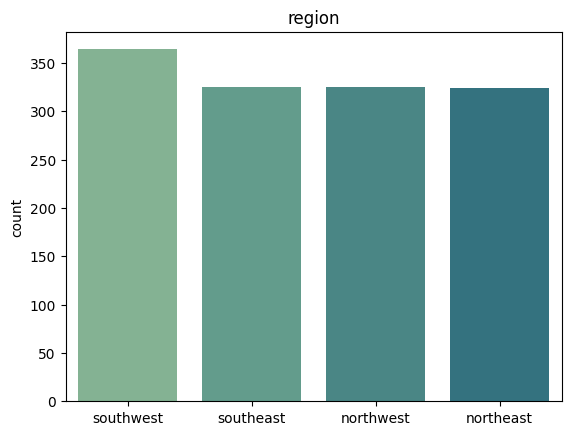

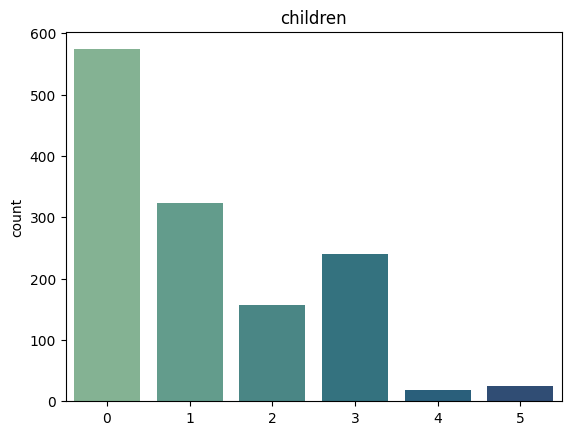

In [10]:
# Bar plots of categorical columns
for col in categorical_columns:
    sns.barplot(x = df[col].unique(), y = df[col].value_counts()).set(title=col)
    plt.show()

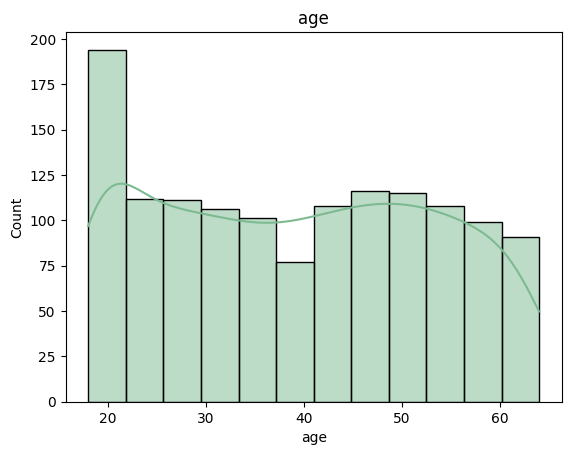

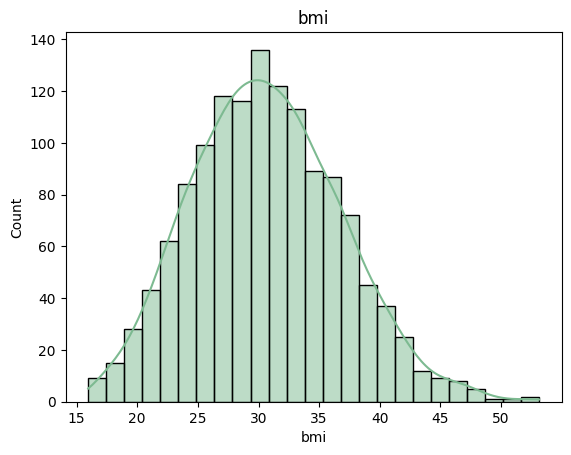

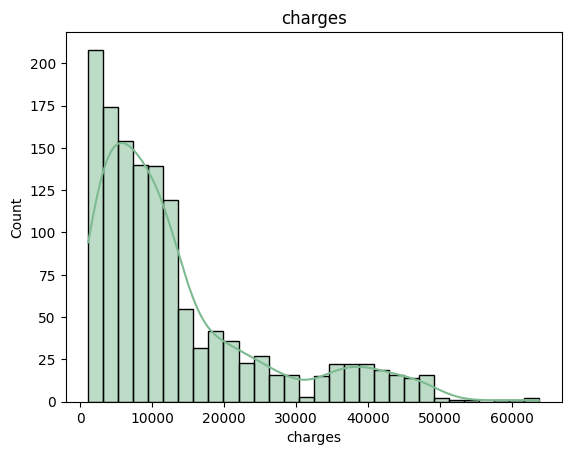

In [11]:
# Histograms of numerical columns
for col in numerical_columns:
    sns.histplot(data=df, x=col, kde=True).set(title=col)
    plt.show()

"age" plot: This histogram is uniform a uniform histogram
"bmi" plot: This histogram is normal histogram but has outliers.
"charges" plot: This histogram is left skewed histogram.

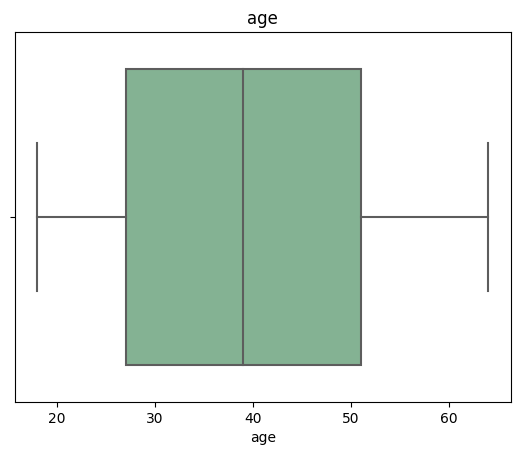

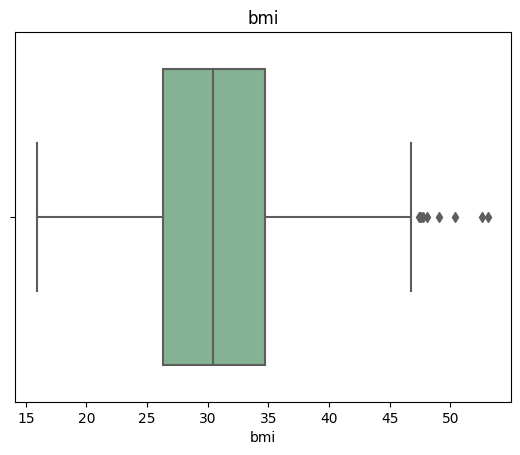

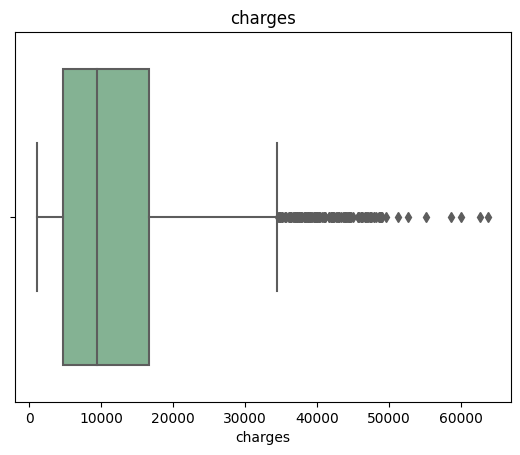

In [12]:
# Box plots of numerical columns
for col in numerical_columns:
    sns.boxplot(data=df, x=col).set(title=col)
    plt.show()

There are outliers in "bmi" and "charges".

In [13]:
# Categorical columns vs. target variable
for col in categorical_columns:
    print(df.groupby(col)["charges"].agg("mean"))
    print("------------------------------------------")

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64
------------------------------------------
children
0    12365.975602
1    12731.171832
2    15073.563734
3    15355.318367
4    13850.656311
5     8786.035247
Name: charges, dtype: float64
------------------------------------------


According to these informations:
* Men have the higher charges.
* Smokers have higher charges.
* Those living in the east have higher charges.
* Those with 5 children have less charges.

## Feature Engineering

In [14]:
df["age_range"] = ""
for idx,age in enumerate(df["age"]):
    if age<=30:
        df["age_range"][idx] = "young adult"
    if age>30 and age<=50:
        df["age_range"][idx] = "middle-aged adult"
    if age>50:
        df["age_range"][idx] = "old adult"
df.head()

,age,sex,bmi,children,smoker,region,charges,age_range
0,19,female,27.900,0,yes,southwest,16884.92400,young adult
1,18,male,33.770,1,no,southeast,1725.55230,young adult
2,28,male,33.000,3,no,southeast,4449.46200,young adult
3,33,male,22.705,0,no,northwest,21984.47061,middle-aged adult
4,32,male,28.880,0,no,northwest,3866.85520,middle-aged adult


In [15]:
df.drop(columns=["age"], inplace=True)
df.head()

,sex,bmi,children,smoker,region,charges,age_range
0,female,27.900,0,yes,southwest,16884.92400,young adult
1,male,33.770,1,no,southeast,1725.55230,young adult
2,male,33.000,3,no,southeast,4449.46200,young adult
3,male,22.705,0,no,northwest,21984.47061,middle-aged adult
4,male,28.880,0,no,northwest,3866.85520,middle-aged adult


In [16]:
df["bmi_range"] = ""
for idx,bmi in enumerate(df["bmi"]):
    if bmi<=18.5:
        df["bmi_range"][idx] = "underweight"
    if bmi>18.5 and bmi<=24.9:
        df["bmi_range"][idx] = "healthy"
    if bmi>24.9 and bmi<=29.9:
        df["bmi_range"][idx] = "overweight"
    if bmi>29.9 and bmi<=39.9:
        df["bmi_range"][idx] = "obesity"
    if bmi>39.9:
        df["bmi_range"][idx] = "severe obesity"
df.head()

,sex,bmi,children,smoker,region,charges,age_range,bmi_range
0,female,27.900,0,yes,southwest,16884.92400,young adult,overweight
1,male,33.770,1,no,southeast,1725.55230,young adult,obesity
2,male,33.000,3,no,southeast,4449.46200,young adult,obesity
3,male,22.705,0,no,northwest,21984.47061,middle-aged adult,healthy
4,male,28.880,0,no,northwest,3866.85520,middle-aged adult,overweight


In [17]:
df.drop(columns=["bmi"], inplace=True)
df.head()

,sex,children,smoker,region,charges,age_range,bmi_range
0,female,0,yes,southwest,16884.92400,young adult,overweight
1,male,1,no,southeast,1725.55230,young adult,obesity
2,male,3,no,southeast,4449.46200,young adult,obesity
3,male,0,no,northwest,21984.47061,middle-aged adult,healthy
4,male,0,no,northwest,3866.85520,middle-aged adult,overweight


In [18]:
categorical_columns, numerical_columns, binary_columns = column_types(df)
print(categorical_columns, numerical_columns, binary_columns)

['region', 'age_range', 'bmi_range', 'children'] ['charges'] ['sex', 'smoker']


In [19]:
# Label Encoding to binary columns
for col in binary_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
df.head()

,sex,children,smoker,region,charges,age_range,bmi_range
0,0,0,1,southwest,16884.92400,young adult,overweight
1,1,1,0,southeast,1725.55230,young adult,obesity
2,1,3,0,southeast,4449.46200,young adult,obesity
3,1,0,0,northwest,21984.47061,middle-aged adult,healthy
4,1,0,0,northwest,3866.85520,middle-aged adult,overweight


In [20]:
# One Hot Encoding to categorical columns
df = pd.get_dummies(df, columns = categorical_columns, drop_first=True, dtype=int) 
df.head()

,sex,smoker,charges,region_northwest,region_southeast,region_southwest,age_range_old adult,age_range_young adult,bmi_range_obesity,bmi_range_overweight,bmi_range_severe obesity,bmi_range_underweight,children_1,children_2,children_3,children_4,children_5
0,0,1,16884.92400,0,0,1,0,1,0,1,0,0,0,0,0,0,0
1,1,0,1725.55230,0,1,0,0,1,1,0,0,0,1,0,0,0,0
2,1,0,4449.46200,0,1,0,0,1,1,0,0,0,0,0,1,0,0
3,1,0,21984.47061,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,3866.85520,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [21]:
X = np.array(df.drop(columns=["charges"]))
y = np.array(df["charges"])

In [22]:
def models(X, y):
    models = {"LR": LinearRegression(),
              "XGB": xgboost.XGBRegressor(),
              "DTR": DecisionTreeRegressor(),
              "RFR": RandomForestRegressor(),
              "Ridge": Ridge(),
              "Lasso": Lasso(),
              "KNN": KNeighborsRegressor(),
              "GB": GradientBoostingRegressor(),
              "LGM": LGBMRegressor()}
    for model in models:
        score = cross_val_score(models[model], X, y, cv=5)
        print(f"{model} Score: {score.mean()}")

In [23]:
models(X, y)

LR Score: 0.7385125065096382
XGB Score: 0.7920868928934058
DTR Score: 0.7682870438782512
RFR Score: 0.8038528132299186
Ridge Score: 0.7386045582866944
Lasso Score: 0.7385281646114559
KNN Score: 0.6509508303577183
GB Score: 0.8390253320672381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 14
[LightGBM] [Info] Start training from score 13182.325247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 14
[LightGBM] [Info] Start training from score 13325.937689
[LightGB

## Hyperparameter Tuning

In [24]:
#GB Hyperparameter Tuning
model = GradientBoostingRegressor()
gb_params = {"n_estimators": [50, 70, 90],
             "min_samples_leaf": [4, 5, 6, 15]
             }
best_grid = GridSearchCV(model,
                         gb_params,
                         cv=5,
                         n_jobs=-1,
                         verbose=1).fit(X, y)
print(best_grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.8450276590275612


## References
* https://www.researchgate.net/figure/Age-intervals-and-age-groups_tbl1_228404297
* https://www.nhsinform.scot/healthy-living/food-and-nutrition/healthy-eating-and-weight-loss/body-mass-index-bmi/
* https://scikit-learn.org/stable/index.html
* https://github.com/senapeksin/Miuul-MachineLearning/blob/master/Machine_Learning/cart.py